In [1]:
import numpy as np
import scipy
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

TITANIC_PATH = "datasets/Titanic/train.csv"


import warnings
warnings.filterwarnings('ignore')

def load_titanic_data(titanic_path = TITANIC_PATH):
    return pd.read_csv(TITANIC_PATH)

tit_data = load_titanic_data()
#print(tit_data.info)

tit_data2 = tit_data.copy()

#appending an 'X' for tickets with no prefix and making two new columns
tit_data2['Ticket'] = tit_data2['Ticket'].apply(lambda x: x.replace(' ','', 1) if len(x.split()) == 3 else x)
tit_data2['Ticket'] = tit_data2['Ticket'].apply(lambda x: ('X ' + x ) if len(x.split()) == 1 else x)
tit_data2[['TktPre', 'TktNum']] = tit_data2.Ticket.str.split(' ', expand = True)
tit_data2["TktNum"] = tit_data2["TktNum"].replace('LINE', 0)

#Getting values for TktPre for getting dummies
a = tit_data2.TktPre.value_counts().index
cat1, cat2, cat3, cat4 = a[0], a[1:5], a[5:16], a[16:]
tit_data2["TktPre"] = tit_data2["TktPre"].apply(lambda x: (x in cat1 and 'cat1') or (x in cat2 and 'cat2') or (x in cat3 and 'cat3') or 'cat4')


#separating labels and training, randomizing the sequence of the samples

X_train = tit_data2.values
y_train = (tit_data2["Survived"]).values

#shuffle_index = np.random.permutation(891)    #0 to 890
#X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
X_train = pd.DataFrame(X_train, columns = tit_data2.columns)

#making dummy variables for the string features
string_feats = X_train[['Sex', 'Embarked', 'TktPre']]
gd = pd.get_dummies(string_feats, prefix = ['Sex', 'Embarked', 'TktPre'])


#joining dummies and originals
X_train.drop(["Sex", "Embarked", "Cabin", "Name", "Survived", "Name", "Ticket", "PassengerId", "TktPre"], axis = 1, inplace = True)
X_train = pd.concat([X_train, gd], axis = 1 )

#putting median age in the Nans
X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)

print(X_train.columns)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TktNum', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'TktPre_cat1',
       'TktPre_cat2', 'TktPre_cat3', 'TktPre_cat4'],
      dtype='object')


In [2]:
#Removing outliers

from collections import Counter
print("training set before removing outliers ", X_train.shape)

#removing otliers from the data
def remove_outlier_rows(f_name_array, given_number):
    outlier_cols = []
    
    for one_col in f_name_array:
        P1 = np.percentile(X_train[one_col], 25)
        P2 = np.percentile(X_train[one_col], 75)
        IQR = P2 - P1
        outlier_step = 1.5 * IQR
       
        indices_outlier_rows = X_train[(X_train[one_col] > P2 + outlier_step) | (X_train[one_col] < P1 - outlier_step)].index
        #print(X_train[(X_train[one_col] > P2 + IQR) | (X_train[one_col] < P1 - IQR)])
        outlier_cols.extend(indices_outlier_rows)
       
    check = Counter(outlier_cols)
    
    rows_to_remove = [k for k,v in check.items() if v > given_number]
    #print((rows_to_remove))

    X_train.drop(rows_to_remove, inplace = True)
    return rows_to_remove

rows_removed = remove_outlier_rows(["Age", "Parch", "SibSp", "Fare"], 2)
y_train = np.delete(y_train, rows_removed, 0)
print("training set shape ",X_train.shape)
print("training labels shape ", y_train.shape) 


training set before removing outliers  (891, 15)
training set shape  (866, 15)
training labels shape  (866,)


In [3]:

# X_train["fam_size"] = X_train["SibSp"] + X_train["Parch"]
# X_train.drop(["PassengerId", "SibSp", "Parch"], axis = 1, inplace = True)


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

sgd_clf = SGDClassifier()
sgd_scrs = cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
print("(SGD non scaled)", sgd_scrs)


#using randomforestclassifier unscaled
forest_clf = RandomForestClassifier(random_state = 42)
frst_scrs = cross_val_score(forest_clf, X_train, y_train, cv = 3, scoring = "accuracy")
print("(Random Forest unscaled)", frst_scrs)


# #using standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TktNum']] = scaler.fit_transform(X_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TktNum']].astype(np.float64))

# #using randomforestclassifier scaled
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
frst_scrs = cross_val_score(forest_clf, X_train, y_train, cv = 3, scoring = "accuracy")
print("(Random Forest scaled)", frst_scrs)


(SGD non scaled) [0.38754325 0.60553633 0.61111111]
(Random Forest unscaled) [0.79584775 0.79930796 0.81597222]
(Random Forest scaled) [0.77854671 0.8200692  0.81944444]


<BarContainer object of 3 artists>

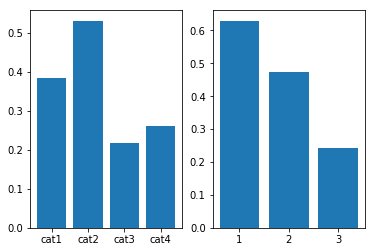

In [5]:
survivability_pclass = tit_data.groupby(["Pclass"])["Survived"].mean()
Pclass_values = tit_data.groupby(["Pclass"]).groups.keys()

survivability_tktpre = tit_data2.groupby(['TktPre'])['Survived'].mean()
TktPre_values = tit_data2.groupby(['TktPre']).groups.keys()

plt.subplot(1,2,1)
plt.bar(TktPre_values, survivability_tktpre)
plt.subplot(1,2,2)
plt.bar(Pclass_values, survivability_pclass)
plt.ylabel('surv'

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
params = {
    'n_estimators': randint(100,500),
     'max_features': randint(1, 11)
}
 
newgridsearch = RandomizedSearchCV(forest_clf, param_distributions = params, n_iter=10, cv = 5, scoring='accuracy')
r_grid_search = newgridsearch.fit(X_train, y_train)
r_cv = r_grid_search.cv_results_

for score, params in zip(r_cv["mean_test_score"], r_cv["params"]):
    print(score, params)

In [ ]:
# tit_data2survivability = tit_data.groupby(["Pclass"])["Survived"].mean()
# Pclass_values = tit_data.groupby(["Pclass"]).groups.keys()
# # print(a)
# # at = [len(v) for k,v in te.groups.items()]
# # at
# plt.bar(Pclass_values, survivability)

